In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn

# Load dataframes
awards_players = pd.read_csv('../data/awards_players.csv')
coaches = pd.read_csv('../data/coaches.csv')
players_teams = pd.read_csv('../data/players_teams.csv')
players = pd.read_csv('../data/players.csv')
series_post = pd.read_csv('../data/series_post.csv')
teams_post = pd.read_csv('../data/teams_post.csv')
teams = pd.read_csv('../data/teams.csv')

teamsYY = pd.read_csv('../data/seasonYY/teams.csv')
players_teamsYY = pd.read_csv('../data/seasonYY/players_teams.csv')
coachesYY = pd.read_csv('../data/seasonYY/coaches.csv') 

In [83]:
df_YY = [teamsYY, players_teamsYY, coachesYY]
df_1_10 = [teams, players_teams, coaches]

for idx in range(len(df_YY)):
    # Performing a left join on common columns
    merged_df = pd.merge(df_YY[idx], df_1_10[idx], on=list(df_YY[idx].columns), how='left')

    # Finding columns present in df2 but not in df1
    additional_cols = [col for col in df_1_10[idx].columns if col not in df_YY[idx].columns]

    # Filling missing values in the merged dataframe for additional columns with zeros
    merged_df[additional_cols] = merged_df[additional_cols].fillna(-1) #if replace with 0 the wasPresent won't get set properly

    df_1_10[idx] = pd.concat([df_1_10[idx], merged_df], ignore_index=True)

teams = df_1_10[0]
players_teams = df_1_10[1]
coaches = df_1_10[2]

In [84]:
# Cleaning Awards Players
# Drop lgID column since all values are 'WNBA'
awards_players.drop('lgID', axis=1, inplace=True)

#Add the missing "award" value for line 30
awards_players.at[28, 'award'] = "Kim Perrot Sportsmanship Award" 
awards_players.head(10)

,playerID,award,year
0,thompti01w,All-Star Game Most Valuable Player,1
1,leslili01w,All-Star Game Most Valuable Player,2
2,leslili01w,All-Star Game Most Valuable Player,3
3,teaslni01w,All-Star Game Most Valuable Player,4
4,swoopsh01w,All-Star Game Most Valuable Player,6
5,douglka01w,All-Star Game Most Valuable Player,7
6,fordch01w,All-Star Game Most Valuable Player,8
7,cashsw01w,All-Star Game Most Valuable Player,10
8,coopemi01w,Coach of the Year,1
9,hugheda99w,Coach of the Year,2


In [85]:
# We can drop 'lgID', since all values are 'WNBA'
players_teams.drop('lgID', axis=1, inplace=True)

In [86]:
# We can drop 'lgID', since all values are 'WNBA'
teams_post.drop('lgID', axis=1, inplace=True)

In [87]:
# We can drop 'lgIDWinner and 'lgIDLoser', since all values are 'WNBA'
series_post.drop(['lgIDWinner', 'lgIDLoser'], axis=1, inplace=True)

In [88]:
# We can drop 'lgID', since all values are 'WNBA'
coaches.drop('lgID', axis=1, inplace=True)

# Rename the column 'stint' to 'stint_coach' to match the other dataframes
coaches.rename(columns={'stint': 'stint_coach'}, inplace=True)

# drop stint_coach
coaches.drop('stint_coach', axis=1, inplace=True)


In [89]:
# We can drop 'firstseason', since all values are '0'
players.drop('firstseason', axis=1, inplace=True)
# We can drop 'lastseason', since all values are '0'
players.drop('lastseason', axis=1, inplace=True)

# We can drop 'collegeOther' since it has a lot of missing values
players.drop('collegeOther', axis=1, inplace=True)

# We can drop 'deathDate' since it is not useful
players.drop('deathDate', axis=1, inplace=True)

# Fill nan values in 'college' with 'none'
players['college'].fillna('none', inplace=True)


# Rename the column 'bioID' to 'playerID' to match the other dataframes
players.rename(columns={'bioID': 'playerID'}, inplace=True)

# Remove players that are coaches
for index, row in players.iterrows():
    # if playerID is in coaches, remove it
    if row['playerID'] in coaches['coachID'].values:
        players.drop(index, inplace=True)

In [90]:
# Filter players with height < 60 inches
players = players[players['height'] >= 60]

In [91]:
# We can drop 'lgID', since all values are 'WNBA'
teams.drop('lgID', axis=1, inplace=True)
# We can drop 'franchID', since values are the same as 'teamID'
teams.drop('franchID', axis=1, inplace=True)
# We can drop 'divID', since all values are null
teams.drop('divID', axis=1, inplace=True)
# We can drop 'seeded', since all values are 0
teams.drop('seeded', axis=1, inplace=True)
# We don't believe that the 'name' attribute is relevant, so we drop it
teams.drop('name', axis=1, inplace=True)
# All of these attributes are always 0, se we can simply drop them
teams.drop(['tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB'], axis=1, inplace=True)
# We don't believe that the 'attend' attribute is relevant, so we drop it
teams.drop('attend', axis=1, inplace=True)
# We don't believe that the 'arena' attribute is relevant, so we drop it
teams.drop('arena', axis=1, inplace=True)

In [92]:
# Filter players with no games played
players_teams = players_teams[players_teams['minutes'] > 0]

### Feature Extraction

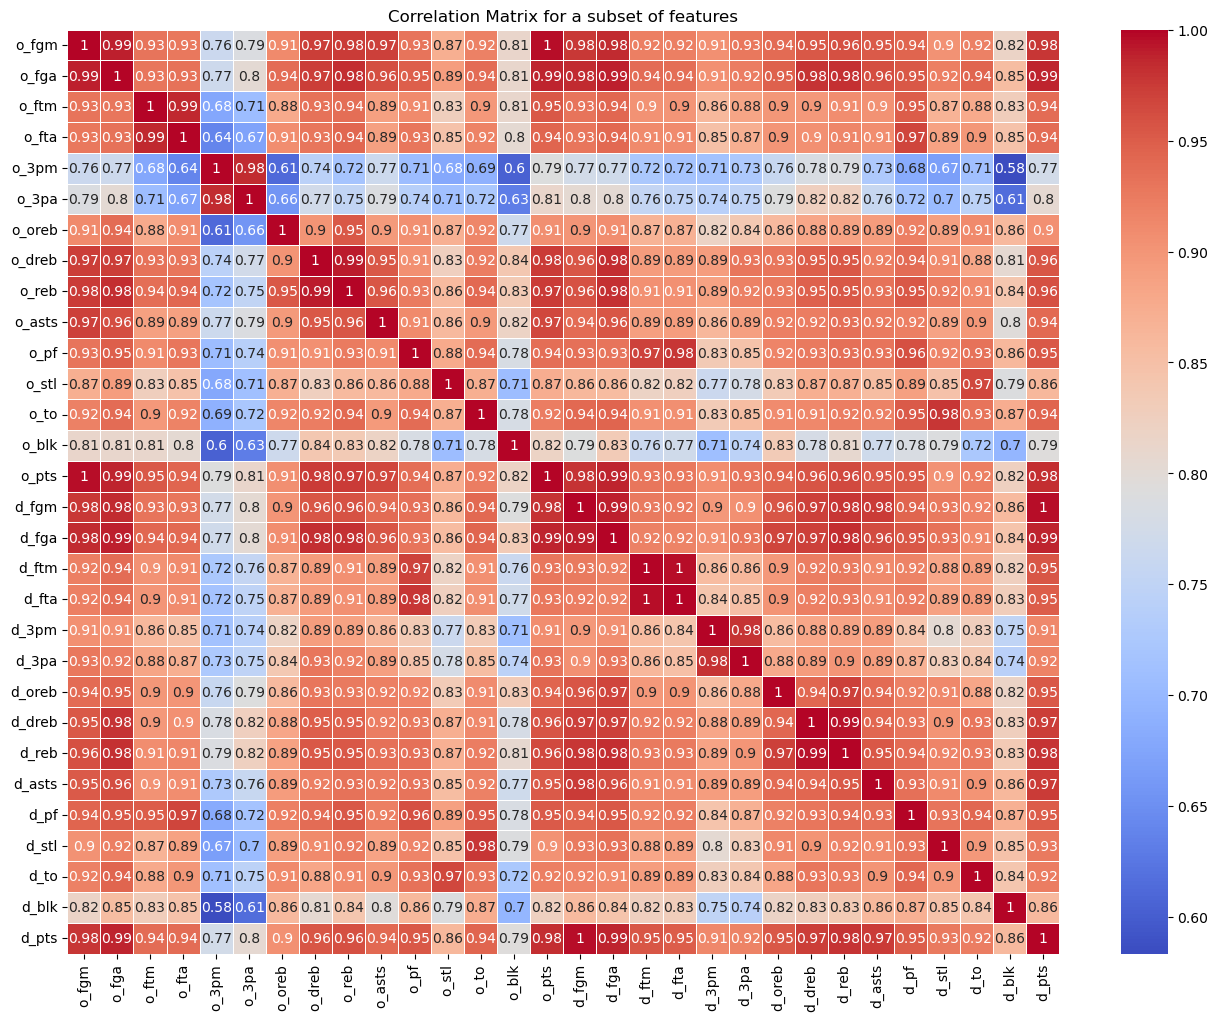

In [93]:
# Select a subset of features
features = ['o_fgm', 'o_fga', 'o_ftm', 'o_fta', 'o_3pm', 'o_3pa',
       'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_pf', 'o_stl', 'o_to', 'o_blk',
       'o_pts', 'd_fgm', 'd_fga', 'd_ftm', 'd_fta', 'd_3pm', 'd_3pa', 'd_oreb',
       'd_dreb', 'd_reb', 'd_asts', 'd_pf', 'd_stl', 'd_to', 'd_blk', 'd_pts']

# Calculate the correlation matrix for the subset of features
corr_matrix = teams[features].corr()

# Create a heatmap to visualize the correlation matrix for the subset of features
plt.figure(figsize=(16, 12))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for a subset of features')
plt.show()

In [94]:
# Drop the columns that are highly correlated
teams.drop(['o_ftm','o_3pm','o_fgm','d_ftm','d_3pm','d_fgm'], axis=1, inplace=True)
teams.drop(['o_oreb', 'o_dreb', 'd_oreb', 'd_dreb'], axis=1, inplace=True)

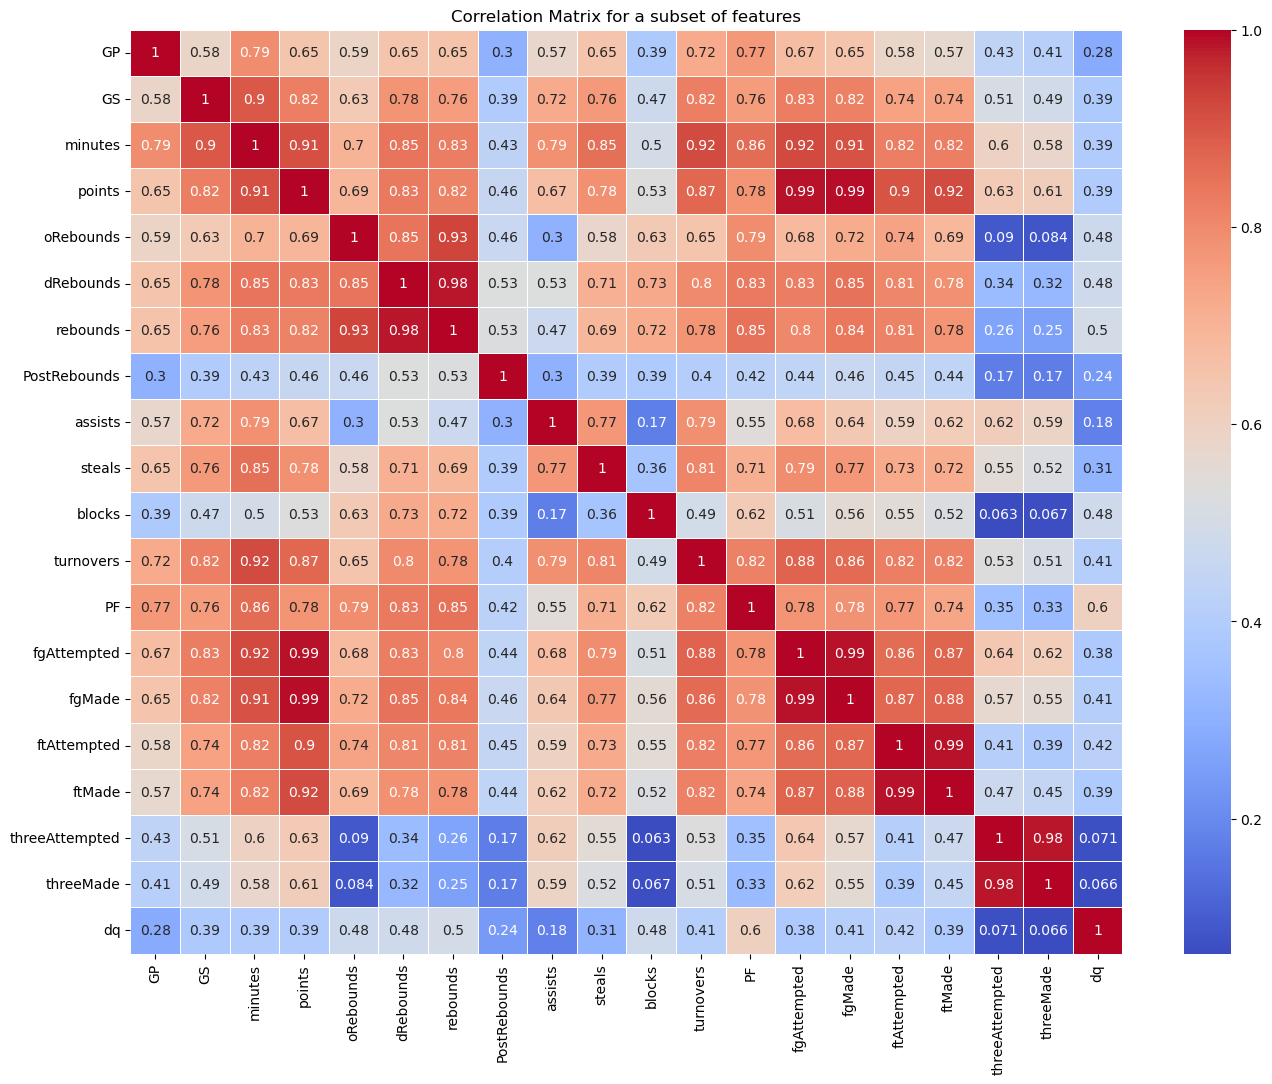

In [95]:
# Select a subset of features
features = ['GP', 'GS', 'minutes',
       'points', 'oRebounds', 'dRebounds', 'rebounds', 'PostRebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted',
       'ftMade', 'threeAttempted', 'threeMade', 'dq']

# Calculate the correlation matrix for the subset of features
corr_matrix = players_teams[features].corr()

# Create a heatmap to visualize the correlation matrix for the subset of features
plt.figure(figsize=(16, 12))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix for a subset of features')
plt.show()

In [96]:
players_teams.drop(['dRebounds'], axis=1, inplace=True)

C:\Users\utilizador\AppData\Local\Temp\ipykernel_19952\4019193551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_teams.drop(['dRebounds'], axis=1, inplace=True)


In [97]:

award_points = {
    'All-Star Game Most Valuable Player': 5,
    'Defensive Player of the Year': 7,
    'Kim Perrot Sportsmanship Award': 0,
    'Most Improved Player': 6,
    'Most Valuable Player': 10,
    'Rookie of the Year': 7,
    'Sixth Woman of the Year': 5,
    'WNBA Finals Most Valuable Player': 9,
    'WNBA All-Decade Team': 10,
    'WNBA All Decade Team Honorable Mention': 5,
    'Coach of the Year': 1
}
awards_players['award_points'] = awards_players['award'].map(award_points)


grouped_df = awards_players.groupby(['playerID', 'year'], as_index=False)['award_points'].sum()

#order it by playerID and then by year
grouped_df = grouped_df.sort_values(by=['playerID', 'year'])


def calculate_last_3_years_sum_awards(player_id, year):
    # Filter the DataFrame for the specific player
    player_data = grouped_df[grouped_df['playerID'] == player_id]
    
    # Get the last 3 years including the current year
    last_years = player_data[(player_data['year'] <= year) & (player_data['year'] > year - 3)]
    
    # Sum the award points, treating non-existent years as 0
    total_points = last_years['award_points'].sum()  # Sum existing points
   
    return total_points

# Add a new column for the last 3 years' sum
grouped_df['last_3_years_sum'] = grouped_df.apply(
    lambda row: calculate_last_3_years_sum_awards(row['playerID'], row['year']), axis=1
)

# Calculate all_time_sum
def calculate_all_time_sum(player_id, current_year):
    # Filter the DataFrame for the specific player
    player_data = grouped_df[grouped_df['playerID'] == player_id]
    
    # Filter for years less than or equal to the current year
    player_data_current_year = player_data[player_data['year'] <= current_year]
    
    # Initialize a variable to hold the sum of award points
    total_points = 0

    # Iterate through the filtered DataFrame
    for index, row in player_data_current_year.iterrows():
        if row["year"] <= current_year:  # Check if the year is less than 5
            total_points += row["award_points"]  # Add award points to total_points

    return total_points

# Add a new column for the all-time sum of points
grouped_df['all_time_sum'] = grouped_df.apply(
    lambda row: calculate_all_time_sum(row['playerID'], row['year']), axis=1
)

# Create a DataFrame for years 1 to 10
years = pd.DataFrame({'year': range(1, 11)})

# Get unique player IDs
unique_players = grouped_df['playerID'].unique()

# Create a DataFrame with all combinations of playerIDs and years
all_combinations = pd.MultiIndex.from_product([unique_players, years['year']], names=['playerID', 'year']).to_frame(index=False)

# Merge with the grouped_df to get existing values
merged_df = all_combinations.merge(
    grouped_df[['playerID', 'year', 'award_points']],
    on=['playerID', 'year'],
    how='left'
)

# Fill NaN values in 'award_points' with 0 (for years with no awards)
merged_df['award_points'] = merged_df['award_points'].fillna(0)


merged_df['last_3_years_sum_awards'] = merged_df.apply(
    lambda row: calculate_last_3_years_sum_awards(row['playerID'], row['year']), axis=1
)

# Add the all_time_sum column
merged_df['all_time_sum_awards'] = merged_df.apply(
    lambda row: calculate_all_time_sum(row['playerID'], row['year']), axis=1
)




In [98]:
# Adding postseason statistics to regular season statistics for each player
for year, lg_data in players_teams.groupby('year'):

    # Retrieve the league statistics
    lg_pts = lg_data['points'].sum() + lg_data['PostPoints'].sum()
    lg_rb = lg_data['rebounds'].sum() + lg_data['PostRebounds'].sum()
    lg_ast = lg_data['assists'].sum() + lg_data['PostAssists'].sum()
    lg_stl = lg_data['steals'].sum() + lg_data['PostSteals'].sum()
    lg_blk = lg_data['blocks'].sum() + lg_data['PostBlocks'].sum()
    lg_to = lg_data['turnovers'].sum() + lg_data['PostTurnovers'].sum()
    lg_pf = lg_data['PF'].sum() + lg_data['PostPF'].sum()
    lg_fga = lg_data['fgAttempted'].sum() + lg_data['PostfgAttempted'].sum()
    lg_fg = lg_data['fgMade'].sum() + lg_data['PostfgMade'].sum()
    lg_fta = lg_data['ftAttempted'].sum() + lg_data['PostftAttempted'].sum()
    lg_ft = lg_data['ftMade'].sum() + lg_data['PostftMade'].sum()
    lg_tra = lg_data['threeAttempted'].sum() + lg_data['PostthreeAttempted'].sum()
    lg_tr = lg_data['threeMade'].sum() + lg_data['PostthreeMade'].sum()

    
    # Calculate the performance of each player in each team
    for playerID, pl_data in lg_data.groupby('playerID'):
        pl_min = pl_data['minutes'].sum() + pl_data['PostMinutes'].sum()
        pl_pts = pl_data['points'].sum() + pl_data['PostPoints'].sum()
        pl_rb = pl_data['rebounds'].sum() + pl_data['PostRebounds'].sum()
        pl_ast = pl_data['assists'].sum() + pl_data['PostAssists'].sum()
        pl_stl = pl_data['steals'].sum() + pl_data['PostSteals'].sum()
        pl_blk = pl_data['blocks'].sum() + pl_data['PostBlocks'].sum()
        pl_fg = pl_data['fgMade'].sum() + pl_data['PostfgMade'].sum()
        pl_ft = pl_data['ftMade'].sum() + pl_data['PostftMade'].sum()
        pl_to = pl_data['turnovers'].sum() + pl_data['PostTurnovers'].sum()
        pl_pf = pl_data['PF'].sum() + pl_data['PostPF'].sum()
        pl_fga = pl_data['fgAttempted'].sum() + pl_data['PostfgAttempted'].sum()
        pl_fta = pl_data['ftAttempted'].sum() + pl_data['PostftAttempted'].sum()
        pl_tr = pl_data['threeMade'].sum() + pl_data['PostthreeMade'].sum()
        pl_tra = pl_data['threeAttempted'].sum() + pl_data['PostthreeAttempted'].sum()

        # Calculate player efficiency
        # Multiply by minutes to give more weight to players with more minutes
        # Also divide by league statistics to normalize

        three_point_accuracy = pl_tr / pl_tra if pl_tra > 0 else 0
        field_goal_accuracy = pl_fg / pl_fga if pl_fga > 0 else 0
        free_throw_accuracy = pl_ft / pl_fta if pl_fta > 0 else 0
        accuracy = three_point_accuracy + field_goal_accuracy + free_throw_accuracy/ 3

        pl_efficiency = (
            (
                pl_pts * 1.2 *accuracy  + pl_rb*0.3 + pl_ast*0.6 + pl_stl*0.5 + pl_blk*0.5 + 
                 - pl_to - pl_pf
            )
        ) * pl_min

        # Round to 2 decimal places
        pl_efficiency = round(pl_efficiency, 2)

        # Add the efficiency to the player's data
        players_teams.loc[pl_data.index, 'pl_efficiency'] = pl_efficiency

players_teams = players_teams.sort_values(by=['playerID', 'year'])
players_teams['last_year_pl_efficiency'] = (
    players_teams.groupby('playerID')['pl_efficiency'].shift(1)
)

# Calculate an average player efficiency for the last 3 years
players_teams['last_3_years_avg_pl_efficiency'] = (
    players_teams.groupby('playerID')['last_year_pl_efficiency'].rolling(window=3, min_periods=1).mean().values
)

# Calculate an average player efficiency for all years
players_teams['all_years_avg_pl_efficiency'] = (
    players_teams.groupby('playerID')['pl_efficiency'].expanding().mean().values
)

    
players_teams.head(20)

C:\Users\utilizador\AppData\Local\Temp\ipykernel_19952\2460559192.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players_teams.loc[pl_data.index, 'pl_efficiency'] = pl_efficiency


,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,rebounds,...,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ,pl_efficiency,last_year_pl_efficiency,last_3_years_avg_pl_efficiency,all_years_avg_pl_efficiency
0,abrossv01w,2,0,MIN,26.0,23.0,846.0,343.0,43.0,174.0,...,0.0,0.0,0.0,0.0,0.0,0.0,268458.24,NaN,NaN,268458.240000
1,abrossv01w,3,0,MIN,27.0,27.0,805.0,314.0,45.0,146.0,...,0.0,0.0,0.0,0.0,0.0,0.0,216489.20,268458.24,268458.240000,242473.720000
2,abrossv01w,4,0,MIN,30.0,25.0,792.0,318.0,44.0,141.0,...,6.0,8.0,8.0,7.0,3.0,0.0,280257.38,216489.20,242473.720000,255068.273333
3,abrossv01w,5,0,MIN,22.0,11.0,462.0,146.0,17.0,74.0,...,8.0,4.0,2.0,8.0,2.0,0.0,83566.93,280257.38,255068.273333,212192.937500
4,abrossv01w,6,0,MIN,31.0,31.0,777.0,304.0,29.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,239521.32,83566.93,193437.836667,217658.614000
5,abrossv01w,7,0,MIN,34.0,2.0,724.0,263.0,44.0,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,195799.85,239521.32,201115.210000,214015.486667
6,abrossv01w,8,0,MIN,34.0,29.0,843.0,345.0,53.0,150.0,...,0.0,0.0,0.0,0.0,0.0,0.0,378821.34,195799.85,172962.700000,237559.180000
7,abrossv01w,9,0,CON,6.0,0.0,107.0,34.0,3.0,20.0,...,11.0,4.0,2.0,5.0,0.0,0.0,6971.40,378821.34,271380.836667,208735.707500
8,adamsjo01w,4,0,MIN,10.0,0.0,96.0,33.0,10.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3561.60,NaN,NaN,3561.600000
9,aguilel01w,3,0,UTA,28.0,0.0,141.0,43.0,0.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8460.47,NaN,NaN,8460.470000


In [99]:
# Drop all columns except the ones we need
players_teams.drop(players_teams.columns.difference(['playerID','tmID', 'year', 'playoff', 'award_points', 'pl_efficiency','last_3_years_avg_pl_efficiency', 'all_years_avg_pl_efficiency']), axis=1, inplace=True)
players_teams.describe()

,year,pl_efficiency,last_3_years_avg_pl_efficiency,all_years_avg_pl_efficiency
count,1873.000000,1.873000e+03,1.319000e+03,1.873000e+03
mean,5.320342,1.838520e+05,2.266871e+05,1.905665e+05
std,2.904075,2.668668e+05,2.577916e+05,2.385407e+05
min,1.000000,-1.245547e+04,-5.183903e+03,-3.649800e+03
25%,3.000000,4.781210e+03,3.042375e+04,1.708811e+04
50%,5.000000,5.921590e+04,1.178049e+05,8.737752e+04
75%,8.000000,2.712419e+05,3.494664e+05,2.975949e+05
max,10.000000,1.663632e+06,1.443595e+06,1.443595e+06


In [100]:
merged_result = pd.merge(players_teams, merged_df, on=['playerID', 'year'], how='left')

merged_result.describe()
merged_result.head(50)

,playerID,year,tmID,pl_efficiency,last_3_years_avg_pl_efficiency,all_years_avg_pl_efficiency,award_points,last_3_years_sum_awards,all_time_sum_awards
0,abrossv01w,2,MIN,268458.24,NaN,268458.240000,NaN,NaN,NaN
1,abrossv01w,3,MIN,216489.20,268458.240000,242473.720000,NaN,NaN,NaN
2,abrossv01w,4,MIN,280257.38,242473.720000,255068.273333,NaN,NaN,NaN
3,abrossv01w,5,MIN,83566.93,255068.273333,212192.937500,NaN,NaN,NaN
4,abrossv01w,6,MIN,239521.32,193437.836667,217658.614000,NaN,NaN,NaN
5,abrossv01w,7,MIN,195799.85,201115.210000,214015.486667,NaN,NaN,NaN
6,abrossv01w,8,MIN,378821.34,172962.700000,237559.180000,NaN,NaN,NaN
7,abrossv01w,9,CON,6971.40,271380.836667,208735.707500,NaN,NaN,NaN
8,adamsjo01w,4,MIN,3561.60,NaN,3561.600000,NaN,NaN,NaN
9,aguilel01w,3,UTA,8460.47,NaN,8460.470000,NaN,NaN,NaN


In [101]:
# merge the players_teams and players dataframes
merged_result = merged_result.merge(players, on='playerID', how='left')
merged_result.describe()
merged_result.head(10)

,playerID,year,tmID,pl_efficiency,last_3_years_avg_pl_efficiency,all_years_avg_pl_efficiency,award_points,last_3_years_sum_awards,all_time_sum_awards,pos,height,weight,college,birthDate
0,abrossv01w,2,MIN,268458.24,NaN,268458.240000,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
1,abrossv01w,3,MIN,216489.20,268458.240000,242473.720000,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
2,abrossv01w,4,MIN,280257.38,242473.720000,255068.273333,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
3,abrossv01w,5,MIN,83566.93,255068.273333,212192.937500,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
4,abrossv01w,6,MIN,239521.32,193437.836667,217658.614000,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
5,abrossv01w,7,MIN,195799.85,201115.210000,214015.486667,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
6,abrossv01w,8,MIN,378821.34,172962.700000,237559.180000,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
7,abrossv01w,9,CON,6971.40,271380.836667,208735.707500,NaN,NaN,NaN,F,74.0,169.0,Connecticut,1980-07-09
8,adamsjo01w,4,MIN,3561.60,NaN,3561.600000,NaN,NaN,NaN,C,75.0,180.0,New Mexico,1981-05-24
9,aguilel01w,3,UTA,8460.47,NaN,8460.470000,NaN,NaN,NaN,G,67.0,165.0,George Washington,1976-10-15


In [102]:
# suppose year 1 is 2000
# if the birthDate is NaN, the age is default will change later
merged_result['birthDate'].fillna('1975-01-01', inplace=True)
merged_result['age'] = merged_result['year'] + 1999 - merged_result['birthDate'].str[:4].astype(int)
merged_result.drop('birthDate', axis=1, inplace=True)


In [103]:
merged_result[(merged_result['tmID'] == 'ATL') & (merged_result['year'] == 9)].head(10)

,playerID,year,tmID,pl_efficiency,last_3_years_avg_pl_efficiency,all_years_avg_pl_efficiency,award_points,last_3_years_sum_awards,all_time_sum_awards,pos,height,weight,college,age
71,balesal01w,9,ATL,78532.35,10059.770000,44296.060000,NaN,NaN,NaN,C,79.0,218.0,Duke,23
276,castriz01w,9,ATL,182683.53,334145.790000,200022.708333,NaN,NaN,NaN,F-G,72.0,140.0,none,26
378,desouer01w,9,ATL,23750.65,15500.095000,18250.280000,NaN,NaN,NaN,F-C,77.0,190.0,none,26
635,haynikr01w,9,ATL,45718.53,87226.040000,76849.162500,NaN,NaN,NaN,G,69.0,147.0,Michigan State,25
856,lacyje01w,9,ATL,62490.94,10960.160000,28137.086667,NaN,NaN,NaN,F,75.0,175.0,Pepperdine,25
876,lattaiv01w,9,ATL,410135.71,29928.130000,220031.920000,NaN,NaN,NaN,G,66.0,143.0,North Carolina,24
901,lennobe01w,9,ATL,671422.92,481090.990000,388927.894000,0.0,0.0,16.0,G,68.0,143.0,Louisiana Tech,32
925,littlca01w,9,ATL,220341.33,96021.360000,158181.345000,NaN,NaN,NaN,F,74.0,180.0,North Carolina,23
938,lovelst01w,9,ATL,31911.99,100706.076667,57225.118571,NaN,NaN,NaN,F,76.0,170.0,Purdue,34
983,mannkr01w,9,ATL,15921.04,168530.556667,130378.177500,NaN,NaN,NaN,F,73.0,185.0,UC Santa Barbara,25


In [104]:
# merge teams and teams_post on 'tmID' and 'year'
teams_all = teams.merge(teams_post, on=['tmID', 'year'], how='left') 

teams_all.rename(columns={'W': 'post_W'}, inplace=True)
teams_all.rename(columns={'L': 'post_L'}, inplace=True)

teams_all.fillna(0, inplace=True)

#order by tmID and year
teams_all = teams_all.sort_values(by=['tmID', 'year'])
teams_all.head(10)

,year,tmID,confID,rank,playoff,firstRound,semis,finals,o_fga,o_fta,...,GP,homeW,homeL,awayW,awayL,confW,confL,min,post_W,post_L
0,9,ATL,EA,7.0,N,0,0,0,2258.0,725.0,...,34.0,1.0,16.0,3.0,14.0,2.0,18.0,6825.0,0.0,0.0
1,10,ATL,EA,2.0,Y,L,0,0,2428.0,755.0,...,34.0,12.0,5.0,6.0,11.0,10.0,12.0,6950.0,0.0,2.0
142,11,ATL,EA,-1.0,-1,-1,-1,-1,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0
2,1,CHA,EA,8.0,N,0,0,0,1903.0,577.0,...,32.0,5.0,11.0,3.0,13.0,5.0,16.0,6475.0,0.0,0.0
3,2,CHA,EA,4.0,Y,W,W,L,1780.0,528.0,...,32.0,11.0,5.0,7.0,9.0,15.0,6.0,6500.0,4.0,4.0
4,3,CHA,EA,2.0,Y,L,0,0,1790.0,663.0,...,32.0,11.0,5.0,7.0,9.0,12.0,9.0,6450.0,0.0,2.0
5,4,CHA,EA,2.0,Y,L,0,0,1881.0,590.0,...,34.0,13.0,4.0,5.0,12.0,12.0,12.0,6850.0,0.0,2.0
6,5,CHA,EA,5.0,N,0,0,0,1744.0,590.0,...,34.0,10.0,7.0,6.0,11.0,8.0,12.0,6900.0,0.0,0.0
7,6,CHA,EA,6.0,N,0,0,0,1913.0,624.0,...,34.0,5.0,12.0,1.0,16.0,4.0,16.0,6945.0,0.0,0.0
8,7,CHA,EA,6.0,N,0,0,0,2178.0,777.0,...,34.0,7.0,10.0,4.0,13.0,6.0,14.0,6825.0,0.0,0.0


### Dados do Ano Passado de Cada Equipa


In [105]:
# Drop columns as needed
teams_all.drop(['firstRound', 'semis', 'finals'], axis=1, inplace=True)

# Separate 'year' column to avoid shifting or prefixing it
year_column = teams_all['year']
confID_column = teams_all['confID']
playoff_column = teams_all['playoff']  
# Shift the DataFrame grouped by 'tmID' to get the previous year's data, excluding 'year'
teams_df_last_year = teams_all.drop(columns=['year', 'confID','playoff']).groupby('tmID').shift(1)

# Add prefix to indicate these are from the last year
teams_df_last_year = teams_df_last_year.add_prefix('last_year_')

# Concatenate 'tmID', 'year' (unchanged), and the shifted columns
teams_df_last_year = pd.concat([teams_all['tmID'], year_column, confID_column,playoff_column, teams_df_last_year], axis=1)

# Fill NaN values with 0 for rows without previous-year data
teams_df_last_year.fillna(0, inplace=True)

# Display the first 10 rows of the result
teams_df_last_year.head(10)


,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,last_year_GP,last_year_homeW,last_year_homeL,last_year_awayW,last_year_awayL,last_year_confW,last_year_confL,last_year_min,last_year_post_W,last_year_post_L
0,ATL,9,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ATL,10,EA,Y,7.0,2258.0,725.0,598.0,1077.0,492.0,...,34.0,1.0,16.0,3.0,14.0,2.0,18.0,6825.0,0.0,0.0
142,ATL,11,EA,-1,2.0,2428.0,755.0,374.0,1259.0,547.0,...,34.0,12.0,5.0,6.0,11.0,10.0,12.0,6950.0,0.0,2.0
2,CHA,1,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CHA,2,EA,Y,8.0,1903.0,577.0,386.0,935.0,551.0,...,32.0,5.0,11.0,3.0,13.0,5.0,16.0,6475.0,0.0,0.0
4,CHA,3,EA,Y,4.0,1780.0,528.0,428.0,948.0,467.0,...,32.0,11.0,5.0,7.0,9.0,15.0,6.0,6500.0,4.0,4.0
5,CHA,4,EA,Y,2.0,1790.0,663.0,527.0,955.0,496.0,...,32.0,11.0,5.0,7.0,9.0,12.0,9.0,6450.0,0.0,2.0
6,CHA,5,EA,N,2.0,1881.0,590.0,517.0,971.0,499.0,...,34.0,13.0,4.0,5.0,12.0,12.0,12.0,6850.0,0.0,2.0
7,CHA,6,EA,N,5.0,1744.0,590.0,459.0,872.0,426.0,...,34.0,10.0,7.0,6.0,11.0,8.0,12.0,6900.0,0.0,0.0
8,CHA,7,EA,N,6.0,1913.0,624.0,301.0,925.0,493.0,...,34.0,5.0,12.0,1.0,16.0,4.0,16.0,6945.0,0.0,0.0


### Dar Merge com os jogadores

In [106]:
# Calculate various averages for each 'year' and 'tmID' and assign them to teams_df_last_year
teams_df_last_year['avg_player_height'] = merged_result.groupby(['year', 'tmID'])['height'].transform('mean')
teams_df_last_year['avg_player_weight'] = merged_result.groupby(['year', 'tmID'])['weight'].transform('mean')
teams_df_last_year['avg_player_age'] = merged_result.groupby(['year', 'tmID'])['age'].transform('mean')
teams_df_last_year['avg_player_last_3_years_sum_awards'] = merged_result.groupby(['year', 'tmID'])['last_3_years_sum_awards'].transform('mean')
teams_df_last_year['avg_player_all_time_sum_awards'] = merged_result.groupby(['year', 'tmID'])['all_time_sum_awards'].transform('mean')

teams_df_last_year['last_3_years_avg_pl_efficiency'] = merged_result.groupby(['year', 'tmID'])['last_3_years_avg_pl_efficiency'].transform('mean')
teams_df_last_year['all_years_avg_pl_efficiency'] = merged_result.groupby(['year', 'tmID'])['all_years_avg_pl_efficiency'].transform('mean')

# Create new attribute 'tm_efficiency' based on the average of 'last_3_years_avg_pl_efficiency' for each team
# teams_df_last_year['tm_efficiency'] = teams_df_last_year.groupby(['year', 'tmID'])['last_3_years_avg_pl_efficiency'].transform('mean')

# Display the first 10 rows of the updated teams_df_last_year DataFrame
teams_df_last_year.head(10)


,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,last_year_min,last_year_post_W,last_year_post_L,avg_player_height,avg_player_weight,avg_player_age,avg_player_last_3_years_sum_awards,avg_player_all_time_sum_awards,last_3_years_avg_pl_efficiency,all_years_avg_pl_efficiency
0,ATL,9,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,72.250000,173.333333,24.833333,3.5,3.5,238964.357143,147083.700417
1,ATL,10,EA,Y,7.0,2258.0,725.0,598.0,1077.0,492.0,...,6825.0,0.0,0.0,72.000000,173.583333,25.250000,3.5,3.5,164582.001515,142542.672569
142,ATL,11,EA,-1,2.0,2428.0,755.0,374.0,1259.0,547.0,...,6950.0,0.0,2.0,71.769231,162.923077,27.461538,0.0,0.0,213432.089091,181895.149231
2,CHA,1,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,72.700000,170.600000,25.636364,0.0,0.0,198613.747593,186908.067227
3,CHA,2,EA,Y,8.0,1903.0,577.0,386.0,935.0,551.0,...,6475.0,0.0,0.0,73.181818,177.000000,25.250000,0.0,0.0,232819.203571,153458.716875
4,CHA,3,EA,Y,4.0,1780.0,528.0,428.0,948.0,467.0,...,6500.0,4.0,4.0,71.333333,166.666667,25.133333,0.0,0.0,142551.622576,116668.208406
5,CHA,4,EA,Y,2.0,1790.0,663.0,527.0,955.0,496.0,...,6450.0,0.0,2.0,72.000000,170.090909,24.454545,7.0,7.0,106673.397292,185857.259545
6,CHA,5,EA,N,2.0,1881.0,590.0,517.0,971.0,499.0,...,6850.0,0.0,2.0,71.416667,162.500000,24.083333,7.0,7.0,226715.272917,185010.092326
7,CHA,6,EA,N,5.0,1744.0,590.0,459.0,872.0,426.0,...,6900.0,0.0,0.0,71.153846,168.000000,24.692308,NaN,NaN,301441.094524,170191.210932
8,CHA,7,EA,N,6.0,1913.0,624.0,301.0,925.0,493.0,...,6945.0,0.0,0.0,72.700000,170.600000,25.636364,0.0,0.0,198613.747593,186908.067227


In [107]:

#merge coachID year in with playerID year to get coach award awards_players and coaches

coaches = coaches.merge(awards_players, how='left', left_on=['year', 'coachID'], right_on=['year', 'playerID'])
#drop playerID anda award
coaches.drop(['playerID', 'award'], axis=1, inplace=True)
#order by coachID
coaches = coaches.sort_values(by=['coachID', 'year'])

coaches['mean_wins'] = (coaches['won'] + coaches['post_wins']) / (coaches['lost'] + coaches['post_losses'])

#coaches mean_wins previous year they coached
# we have to check previous entry for same coachID if none found then its the first year
coaches['last_year_mean_wins_coach'] = coaches.groupby('coachID')['mean_wins'].shift(1)
coaches.fillna(0, inplace=True)


meanYear1 = coaches[coaches['year'] == 1]['mean_wins'].mean()
meanYear2 = coaches[coaches['year'] == 2]['mean_wins'].mean()
meanYear3 = coaches[coaches['year'] == 3]['mean_wins'].mean()
meanYear4 = coaches[coaches['year'] == 4]['mean_wins'].mean()
meanYear5 = coaches[coaches['year'] == 5]['mean_wins'].mean()
meanYear6 = coaches[coaches['year'] == 6]['mean_wins'].mean()
meanYear7 = coaches[coaches['year'] == 7]['mean_wins'].mean()
meanYear8 = coaches[coaches['year'] == 8]['mean_wins'].mean()
meanYear9 = coaches[coaches['year'] == 9]['mean_wins'].mean()

#print all in the same line with forma Year1: meanYear1, Year2: meanYear2, ...
print(f"Year1: {meanYear1}, Year2: {meanYear2}, Year3: {meanYear3}, Year4: {meanYear4}, Year5: {meanYear5}, Year6: {meanYear6}, Year7: {meanYear7}, Year8: {meanYear8}, Year9: {meanYear9}")

mean_wins_by_year = {
    1: meanYear1,
    2: meanYear2,
    3: meanYear3,
    4: meanYear4,
    5: meanYear5,
    6: meanYear6,
    7: meanYear7,
    8: meanYear8,
    9: meanYear9
}


def fill_last_year_mean(row):
    if row['last_year_mean_wins_coach'] == 0.0 and row['year'] != 1:
        # Get the mean of the previous year
        return mean_wins_by_year.get(row['year'] - 1, row['last_year_mean_wins_coach'])
    else:
        # Leave the value as it is
        return row['last_year_mean_wins_coach']


coaches['last_year_mean_wins_coach'] = coaches.apply(fill_last_year_mean, axis=1)







#drop won, post_wins, lost, post_losses
coaches.drop(['won', 'post_wins', 'lost', 'post_losses','mean_wins'], axis=1, inplace=True)

# rename awards_points to award_points_coach
coaches.rename(columns={'award_points': 'award_points_coach'}, inplace=True)
coaches.rename(columns={'mean_wins': 'mean_wins_coach'}, inplace=True)


#merge with teams_all
merged_result = teams_df_last_year.merge(coaches, how='left', left_on=['year', 'tmID'], right_on=['year', 'tmID'])
#drop coachID
merged_result.drop('coachID', axis=1, inplace=True)
#fill NaN with 0
merged_result.fillna(0, inplace=True)
#order by year and tmID
merged_result = merged_result.sort_values(by=['tmID', 'year'])

merged_result.head(20)


Year1: 1.4537209923945529, Year2: 1.3600140924702329, Year3: 1.1247610404731148, Year4: 1.1275522713762844, Year5: 1.1908263305322129, Year6: 1.133720939554273, Year7: 1.1367835328367561, Year8: 1.026700788277524, Year9: 1.0569133767276182


,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,last_year_post_L,avg_player_height,avg_player_weight,avg_player_age,avg_player_last_3_years_sum_awards,avg_player_all_time_sum_awards,last_3_years_avg_pl_efficiency,all_years_avg_pl_efficiency,award_points_coach,last_year_mean_wins_coach
0,ATL,9,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,72.250000,173.333333,24.833333,3.5,3.5,238964.357143,147083.700417,0.0,1.026701
1,ATL,10,EA,Y,7.0,2258.0,725.0,598.0,1077.0,492.0,...,0.0,72.000000,173.583333,25.250000,3.5,3.5,164582.001515,142542.672569,1.0,0.133333
2,ATL,11,EA,-1,2.0,2428.0,755.0,374.0,1259.0,547.0,...,2.0,71.769231,162.923077,27.461538,0.0,0.0,213432.089091,181895.149231,0.0,1.000000
3,CHA,1,EA,N,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,72.700000,170.600000,25.636364,0.0,0.0,198613.747593,186908.067227,0.0,0.000000
4,CHA,2,EA,Y,8.0,1903.0,577.0,386.0,935.0,551.0,...,0.0,73.181818,177.000000,25.250000,0.0,0.0,232819.203571,153458.716875,0.0,0.391304
5,CHA,3,EA,Y,4.0,1780.0,528.0,428.0,948.0,467.0,...,4.0,71.333333,166.666667,25.133333,0.0,0.0,142551.622576,116668.208406,0.0,1.222222
6,CHA,4,EA,Y,2.0,1790.0,663.0,527.0,955.0,496.0,...,2.0,72.000000,170.090909,24.454545,7.0,7.0,106673.397292,185857.259545,0.0,1.124761
7,CHA,5,EA,N,2.0,1881.0,590.0,517.0,971.0,499.0,...,2.0,71.416667,162.500000,24.083333,7.0,7.0,226715.272917,185010.092326,0.0,1.000000
8,CHA,6,EA,N,5.0,1744.0,590.0,459.0,872.0,426.0,...,0.0,71.153846,168.000000,24.692308,0.0,0.0,301441.094524,170191.210932,0.0,1.190826
9,CHA,6,EA,N,5.0,1744.0,590.0,459.0,872.0,426.0,...,0.0,71.153846,168.000000,24.692308,0.0,0.0,301441.094524,170191.210932,0.0,0.888889


In [108]:
# Export the cleaned dataframes to CSV files
merged_result.to_csv("../data/clean/merged.csv", index=False)